The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


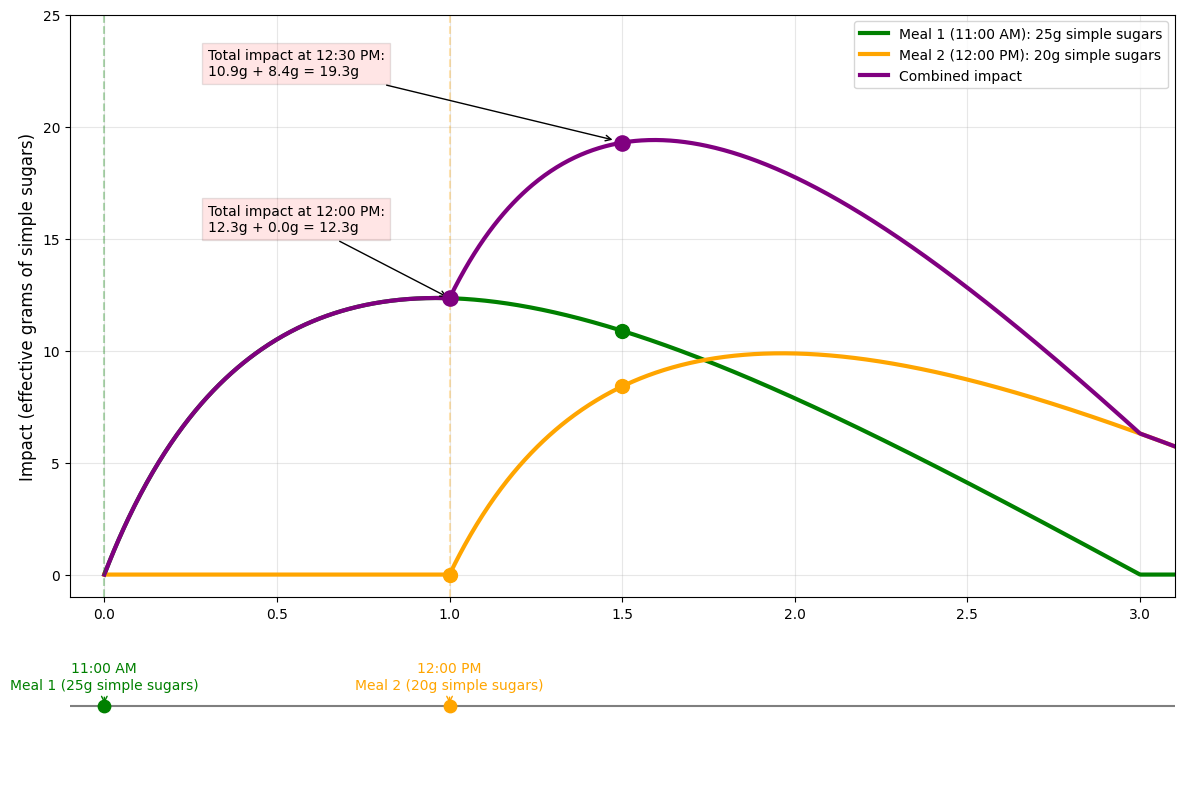

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from scipy.interpolate import interp1d

def bernstein_poly(i, n, t):
    """Bernstein polynomial basis for Bezier curves"""
    return comb(n, i) * (t**i) * ((1-t)**(n-i))

def bezier_curve(points, num=500):
    """Generate Bezier curve from control points with high resolution"""
    n = len(points) - 1
    t = np.linspace(0, 1, num)
    curve = np.zeros((num, 2))
    
    for i, point in enumerate(points):
        curve += np.outer(bernstein_poly(i, n, t), point)
    
    indices = np.argsort(curve[:, 0])
    curve = curve[indices]
    
    return curve

# Control points for simple sugars
control_points = np.array([
    [0.0, 0.0],   # Initial point
    [0.5, 0.8],   # Quick rise
    [1.5, 0.5],   # Start of decline
    [3.0, 0.0]    # Return to baseline
])

# Generate high-resolution curve
curve = bezier_curve(control_points, num=1000)
x_curve = curve[:, 0]
y_curve = curve[:, 1]

# Create interpolation function for smoother lookups
impact_interp = interp1d(x_curve, y_curve, kind='cubic', bounds_error=False, fill_value=0)

# Setup timeline
meal1_time = "11:00 AM"
meal2_time = "12:00 PM"
current_time = "12:00 PM" 
horizon_time = "12:30 PM"

# Amounts of simple sugars in each meal
meal1_sugar = 25  # 25g simple sugars in meal 1
meal2_sugar = 20  # 20g simple sugars in meal 2

# Set up high-resolution time axis (hours from 11:00 AM to 2:30 PM)
time_points = np.linspace(0, 3.5, 1000)  # 0 = 11:00 AM, 3.5 = 2:30 PM

# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [4, 1]})

# Calculate impact curves for each meal using interpolation for smoothness
meal1_impact = np.zeros_like(time_points)
meal2_impact = np.zeros_like(time_points)

for i, t in enumerate(time_points):
    # Meal 1 impact (started at 11:00 AM)
    if 0 <= t <= 3:
        meal1_impact[i] = impact_interp(t) * meal1_sugar
    
    # Meal 2 impact (started at 12:00 PM, so shifted by 1 hour)
    t_adjusted = t - 1  # Adjust for 1 hour difference
    if 0 <= t_adjusted <= 3:
        meal2_impact[i] = impact_interp(t_adjusted) * meal2_sugar

# Calculate combined impact
combined_impact = meal1_impact + meal2_impact

# Plot the three smooth curves
ax1.plot(time_points, meal1_impact, '-', color='green', linewidth=3, 
         label=f'Meal 1 (11:00 AM): 25g simple sugars')
ax1.plot(time_points, meal2_impact, '-', color='orange', linewidth=3, 
         label=f'Meal 2 (12:00 PM): 20g simple sugars')
ax1.plot(time_points, combined_impact, '-', color='purple', linewidth=3, 
         label='Combined impact')

# Mark the prediction horizon (12:00 PM = 1 hour after 11:00 AM)
horizon_idx = np.abs(time_points - 1).argmin()
meal1_horizon_value = meal1_impact[horizon_idx]
meal2_horizon_value = meal2_impact[horizon_idx]
combined_horizon_value = combined_impact[horizon_idx]

# Calculate impact factors at horizon
meal1_horizon_factor = meal1_horizon_value / meal1_sugar
meal2_horizon_factor = meal2_horizon_value / meal2_sugar

# Add data points at prediction horizon
ax1.scatter([1], [meal1_horizon_value], color='green', s=100, zorder=5)
ax1.scatter([1], [meal2_horizon_value], color='orange', s=100, zorder=5)
ax1.scatter([1], [combined_horizon_value], color='purple', s=120, zorder=6)

# Add annotations at 12:00 PM

ax1.annotate(f'Total impact at 12:00 PM:\n{meal1_horizon_value:.1f}g + {meal2_horizon_value:.1f}g = {combined_horizon_value:.1f}g', 
             xy=(1, combined_horizon_value),  # Changed from 1.48 to 1
             xytext=(0.3, combined_horizon_value + 3),
             arrowprops=dict(arrowstyle='->'),
             bbox=dict(facecolor='red', alpha=0.1))


# Add annotations at 12:30 PM

# Mark the prediction horizon (12:30 PM = 1.5 hours after 11:00 AM)
horizon_idx = np.abs(time_points - 1.5).argmin()
meal1_horizon_value = meal1_impact[horizon_idx]
meal2_horizon_value = meal2_impact[horizon_idx]
combined_horizon_value = combined_impact[horizon_idx]

# Calculate impact factors at horizon
meal1_horizon_factor = meal1_horizon_value / meal1_sugar
meal2_horizon_factor = meal2_horizon_value / meal2_sugar

# Add data points at prediction horizon
ax1.scatter([1.5], [meal1_horizon_value], color='green', s=100, zorder=5)
ax1.scatter([1.5], [meal2_horizon_value], color='orange', s=100, zorder=5)
ax1.scatter([1.5], [combined_horizon_value], color='purple', s=120, zorder=6)

ax1.annotate(f'Total impact at 12:30 PM:\n{meal1_horizon_value:.1f}g + {meal2_horizon_value:.1f}g = {combined_horizon_value:.1f}g', 
             xy=(1.48, combined_horizon_value + 0.1),
             xytext=(0.3, combined_horizon_value + 3),
             arrowprops=dict(arrowstyle='->'),
             bbox=dict(facecolor='red', alpha=0.1))


# Add timeline in second subplot
events = [
    (0, meal1_time, "Meal 1 (25g simple sugars)", "green"),
    (1, meal2_time, "Meal 2 (20g simple sugars)", "orange"),
]

ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
for pos, label, desc, color in events:
    ax2.scatter([pos], [0], color=color, s=80, zorder=5)
    ax2.annotate(f"{label}\n{desc}", 
                 xy=(pos, 0), xytext=(pos, 0.1), 
                 ha='center', va='bottom', color=color,
                 arrowprops=dict(arrowstyle='->', color=color))

# Add vertical lines for key time points
ax1.axvline(x=0, color='green', linestyle='--', alpha=0.3)  # 11:00 AM (Meal 1)
ax1.axvline(x=1, color='orange', linestyle='--', alpha=0.3)  # 12:00 PM (Meal 2)

# Set labels and limits
ax1.set_ylabel('Impact (effective grams of simple sugars)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-1, 25)
ax1.set_xlim(-0.1, 3.1)
ax1.legend(loc='upper right')

# Configure timeline subplot
ax2.set_ylim(-0.5, 0.5)
ax2.set_xlim(-0.1, 3.1)
ax2.set_xticks([0, 1, 1.5, 2, 3])
ax2.set_xticklabels(['11:00 AM', '12:00 PM', '12:30 PM', '1:00 PM', '2:00 PM'])
ax2.axis('off')

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)  # Reduce space between subplots
plt.savefig('images/example_bezier.eps', dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


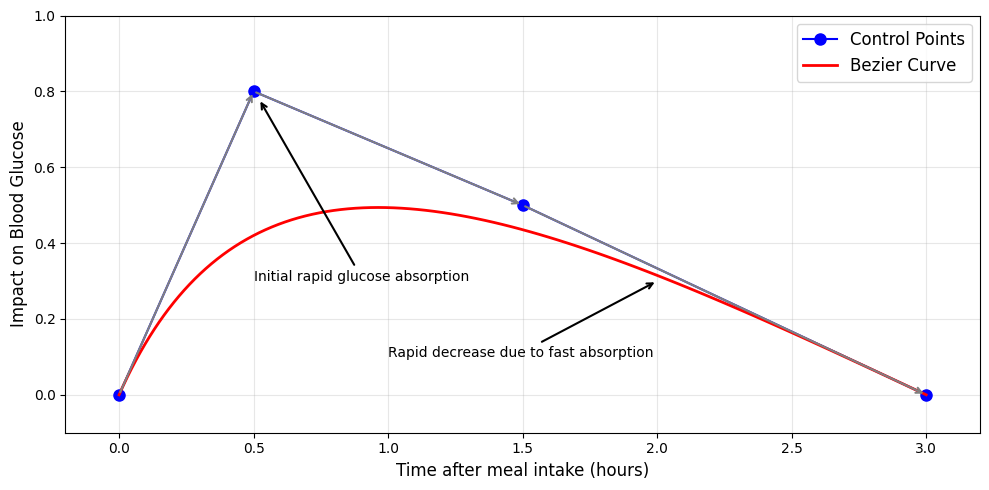

In [3]:
def bernstein_poly(i, n, t):
    """Bernstein polynomial basis for Bezier curves"""
    return comb(n, i) * (t**i) * ((1-t)**(n-i))

def bezier_curve(points, num=100):
    """Generate Bezier curve from control points"""
    n = len(points) - 1  # Degree of curve is n
    t = np.linspace(0, 1, num)
    curve = np.zeros((num, 2))
    
    for i, point in enumerate(points):
        curve += np.outer(bernstein_poly(i, n, t), point)
    
    return curve

# Feature to visualize - using simple sugars as example
feature = 'simple_sugars'
control_points = np.array([
    [0.0, 0.0],   # Initial point (no effect at t=0)
    [0.5, 0.8],   # Quick rise
    [1.5, 0.5],   # Start of decline
    [3.0, 0.0]    # Return to baseline
])

# Generate curve
t = np.linspace(0, 1, 100)
curve = bezier_curve(control_points)

# Create visualization
plt.figure(figsize=(10, 5))

# Plot control points
plt.plot(control_points[:, 0], control_points[:, 1], 'o-', color='blue', 
         label='Control Points', markersize=8)

# Plot Bezier curve
plt.plot(curve[:, 0], curve[:, 1], '-', color='red', linewidth=2, 
         label='Bezier Curve')

# Add arrows to show direction
for i in range(len(control_points)-1):
    plt.annotate('', xy=control_points[i+1], xytext=control_points[i],
                arrowprops=dict(arrowstyle='->', lw=1.5, color='gray'))

plt.xlabel('Time after meal intake (hours)', fontsize=12)
plt.ylabel('Impact on Blood Glucose', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xlim(-0.2, 3.2)
plt.ylim(-0.1, 1.0)

# Add annotation explaining the physiological meaning
plt.annotate('Initial rapid glucose absorption', xy=(0.52, 0.78), xytext=(0.5, 0.3),
            arrowprops=dict(arrowstyle='->', lw=1.5, color='black'), fontsize=10)
plt.annotate('Rapid decrease due to fast absorption', xy=(2.0, 0.3), xytext=(1.0, 0.1),
            arrowprops=dict(arrowstyle='->', lw=1.5, color='black'), fontsize=10)

plt.tight_layout()
plt.savefig('images/bezier_methodology.eps', dpi=300)
plt.show()